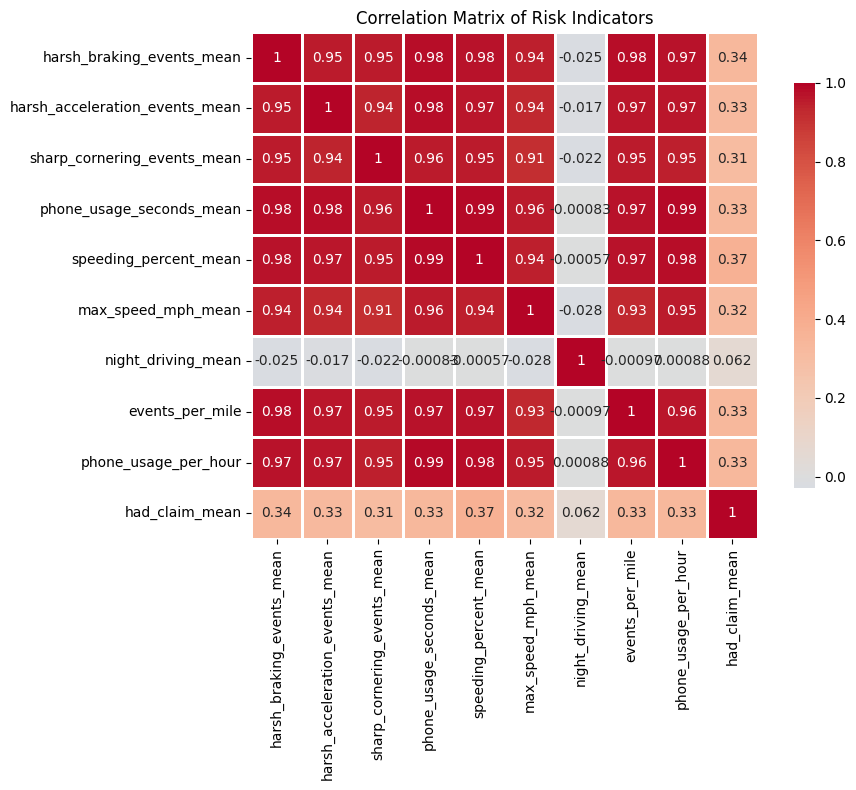

MODEL 1: CLAIM PROBABILITY PREDICTION

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.36      0.45        14
           1       0.59      0.81      0.68        16

    accuracy                           0.60        30
   macro avg       0.61      0.58      0.57        30
weighted avg       0.61      0.60      0.58        30

ROC-AUC Score: 0.6362


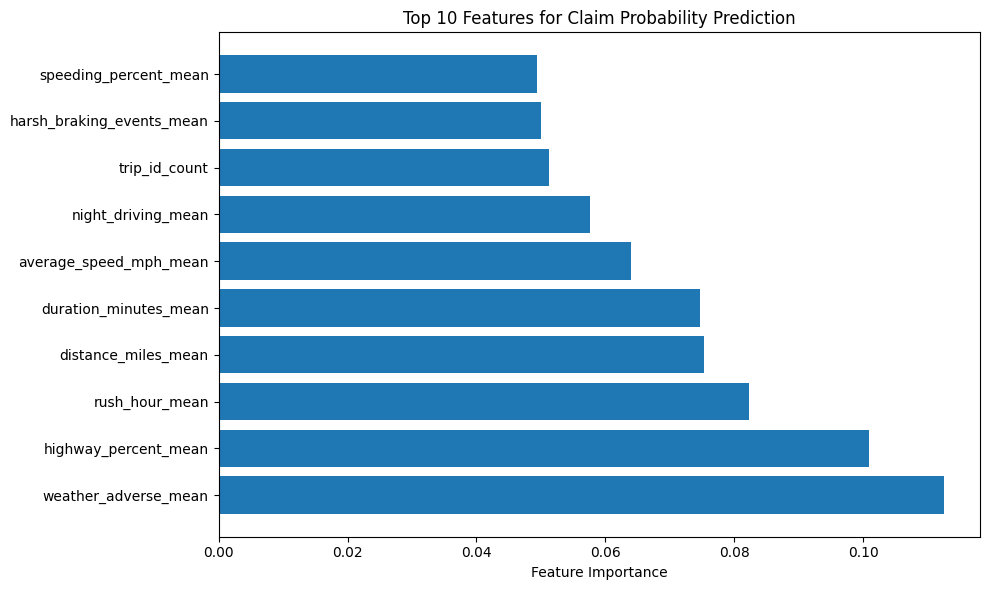


Top 10 Most Important Features:
                      feature  importance
12       weather_adverse_mean    0.112508
11       highway_percent_mean    0.100915
10             rush_hour_mean    0.082281
2         distance_miles_mean    0.075326
1       duration_minutes_mean    0.074747
3      average_speed_mph_mean    0.063928
9          night_driving_mean    0.057607
0               trip_id_count    0.051265
5   harsh_braking_events_mean    0.050034
13      speeding_percent_mean    0.049358

MODEL 2: CLAIM SEVERITY PREDICTION

RMSE for claim severity: $234.42


/tmp/ipykernel_15273/2525718488.py:160: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_factors = df_drivers.groupby('risk_tier')[['harsh_braking_events_mean',


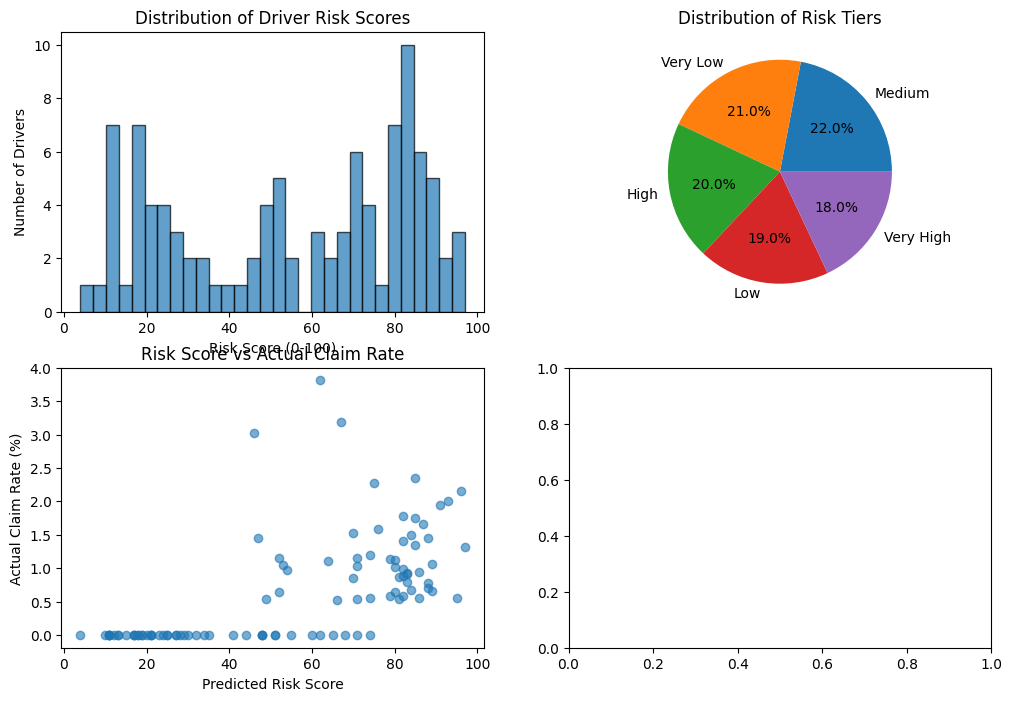

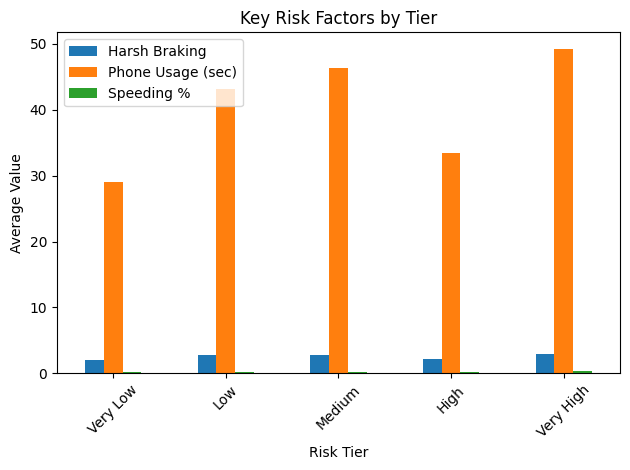


RISK SCORING SUMMARY

Risk Tier Distribution:
risk_tier
Very Low     21
Low          19
Medium       22
High         20
Very High    18
Name: count, dtype: int64

Average Risk Score by Actual Claims:
had_claim_sum
0    30.723404
1    77.857143
2    73.583333
3    78.250000
4    79.000000
Name: risk_score, dtype: float64

Top 5 Highest Risk Drivers:
     driver_id  risk_score  risk_tier  claim_probability  had_claim_sum  \
21  DRIVER_021        97.0  Very High               0.97              2   
83  DRIVER_083        96.0  Very High               0.96              4   
92  DRIVER_092        95.0  Very High               0.95              1   
96  DRIVER_096        93.0  Very High               0.93              2   
9   DRIVER_009        91.0  Very High               0.91              3   

    claim_amount_sum  
21      23340.900770  
83      91214.251052  
92       7656.517380  
96       5648.566764  
9       23633.272557  


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load the driver-level data
df_drivers = pd.read_csv('driver_aggregated_features.csv')

# 1. FEATURE ENGINEERING
# Create additional risk-related features
df_drivers['events_per_mile'] = (df_drivers['harsh_braking_events_sum'] + 
                                  df_drivers['harsh_acceleration_events_sum'] + 
                                  df_drivers['sharp_cornering_events_sum']) / df_drivers['distance_miles_sum']

df_drivers['phone_usage_per_hour'] = df_drivers['phone_usage_seconds_sum'] / (df_drivers['duration_minutes_sum'] / 60)

df_drivers['night_driving_miles'] = df_drivers['night_driving_mean'] * df_drivers['distance_miles_sum']

df_drivers['speeding_severity'] = df_drivers['speeding_percent_mean'] * df_drivers['max_speed_mph_mean']

# Create risk categories based on claims
df_drivers['risk_category'] = pd.cut(df_drivers['had_claim_mean'], 
                                     bins=[-0.001, 0, 0.01, 0.02, 1], 
                                     labels=['No Risk', 'Low Risk', 'Medium Risk', 'High Risk'])

# 2. EXPLORATORY DATA ANALYSIS
# Create correlation matrix for key features
risk_features = ['harsh_braking_events_mean', 'harsh_acceleration_events_mean', 
                 'sharp_cornering_events_mean', 'phone_usage_seconds_mean',
                 'speeding_percent_mean', 'max_speed_mph_mean', 'night_driving_mean',
                 'events_per_mile', 'phone_usage_per_hour', 'had_claim_mean']

plt.figure(figsize=(10, 8))
correlation_matrix = df_drivers[risk_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Risk Indicators')
plt.tight_layout()
plt.savefig('risk_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. PREPARE DATA FOR MODELING
# Select features for modeling
feature_cols = ['trip_id_count', 'duration_minutes_mean', 'distance_miles_mean',
                'average_speed_mph_mean', 'max_speed_mph_mean', 
                'harsh_braking_events_mean', 'harsh_acceleration_events_mean',
                'sharp_cornering_events_mean', 'phone_usage_seconds_mean',
                'night_driving_mean', 'rush_hour_mean', 'highway_percent_mean',
                'weather_adverse_mean', 'speeding_percent_mean',
                'events_per_mile', 'phone_usage_per_hour', 'speeding_severity']

X = df_drivers[feature_cols]
y_binary = (df_drivers['had_claim_sum'] > 0).astype(int)  # Binary: had any claim
y_continuous = df_drivers['claim_amount_mean']  # Continuous: average claim amount

# Split data
X_train, X_test, y_train_binary, y_test_binary, y_train_cont, y_test_cont = train_test_split(
    X, y_binary, y_continuous, test_size=0.3, random_state=42, stratify=y_binary
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. MODEL 1: CLAIM PROBABILITY MODEL (Classification)
print("=" * 50)
print("MODEL 1: CLAIM PROBABILITY PREDICTION")
print("=" * 50)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, 
                                      class_weight='balanced')
rf_classifier.fit(X_train_scaled, y_train_binary)

# Predictions
y_pred_binary = rf_classifier.predict(X_test_scaled)
y_pred_proba = rf_classifier.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary))
print(f"ROC-AUC Score: {roc_auc_score(y_test_binary, y_pred_proba):.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xlabel('Feature Importance')
plt.title('Top 10 Features for Claim Probability Prediction')
plt.tight_layout()
plt.savefig('feature_importance_claims.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# 5. MODEL 2: CLAIM SEVERITY MODEL (Regression)
print("\n" + "=" * 50)
print("MODEL 2: CLAIM SEVERITY PREDICTION")
print("=" * 50)

# Filter only drivers with claims for severity modeling
mask_train = y_train_cont > 0
mask_test = y_test_cont > 0

if mask_train.sum() > 10:  # Only if we have enough samples
    gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gb_regressor.fit(X_train_scaled[mask_train], np.log1p(y_train_cont[mask_train]))
    
    y_pred_severity = np.expm1(gb_regressor.predict(X_test_scaled[mask_test]))
    
    rmse = np.sqrt(mean_squared_error(y_test_cont[mask_test], y_pred_severity))
    print(f"\nRMSE for claim severity: ${rmse:,.2f}")

# 6. COMBINED RISK SCORE
# Create a combined risk score
df_drivers['claim_probability'] = rf_classifier.predict_proba(scaler.transform(X))[:, 1]

# Normalize scores to 0-100 scale
df_drivers['risk_score'] = (df_drivers['claim_probability'] * 100).round(1)

# Create risk tiers
df_drivers['risk_tier'] = pd.qcut(df_drivers['risk_score'], 
                                  q=5, 
                                  labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# 7. RISK PROFILE VISUALIZATION
plt.figure(figsize=(12, 8))

# Subplot 1: Risk Score Distribution
plt.subplot(2, 2, 1)
plt.hist(df_drivers['risk_score'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Risk Score (0-100)')
plt.ylabel('Number of Drivers')
plt.title('Distribution of Driver Risk Scores')

# Subplot 2: Risk Tier Distribution
plt.subplot(2, 2, 2)
risk_tier_counts = df_drivers['risk_tier'].value_counts()
plt.pie(risk_tier_counts.values, labels=risk_tier_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Risk Tiers')

# Subplot 3: Risk Score vs Actual Claims
plt.subplot(2, 2, 3)
plt.scatter(df_drivers['risk_score'], df_drivers['had_claim_mean'] * 100, alpha=0.6)
plt.xlabel('Predicted Risk Score')
plt.ylabel('Actual Claim Rate (%)')
plt.title('Risk Score vs Actual Claim Rate')

# Subplot 4: Top Risk Factors by Tier
plt.subplot(2, 2, 4)
risk_factors = df_drivers.groupby('risk_tier')[['harsh_braking_events_mean', 
                                                'phone_usage_seconds_mean', 
                                                'speeding_percent_mean']].mean()
risk_factors.plot(kind='bar')
plt.xlabel('Risk Tier')
plt.ylabel('Average Value')
plt.title('Key Risk Factors by Tier')
plt.xticks(rotation=45)
plt.legend(['Harsh Braking', 'Phone Usage (sec)', 'Speeding %'], loc='upper left')

plt.tight_layout()
plt.savefig('risk_analysis_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

# 8. SAVE FINAL RISK SCORES
output_df = df_drivers[['driver_id', 'risk_score', 'risk_tier', 'claim_probability',
                       'had_claim_sum', 'claim_amount_sum']].copy()
output_df.to_csv('driver_risk_scores.csv', index=False)

print("\n" + "=" * 50)
print("RISK SCORING SUMMARY")
print("=" * 50)
print(f"\nRisk Tier Distribution:")
print(df_drivers['risk_tier'].value_counts().sort_index())
print(f"\nAverage Risk Score by Actual Claims:")
print(df_drivers.groupby('had_claim_sum')['risk_score'].mean())

# Show sample of high-risk drivers
print("\nTop 5 Highest Risk Drivers:")
high_risk = output_df.nlargest(5, 'risk_score')
print(high_risk)

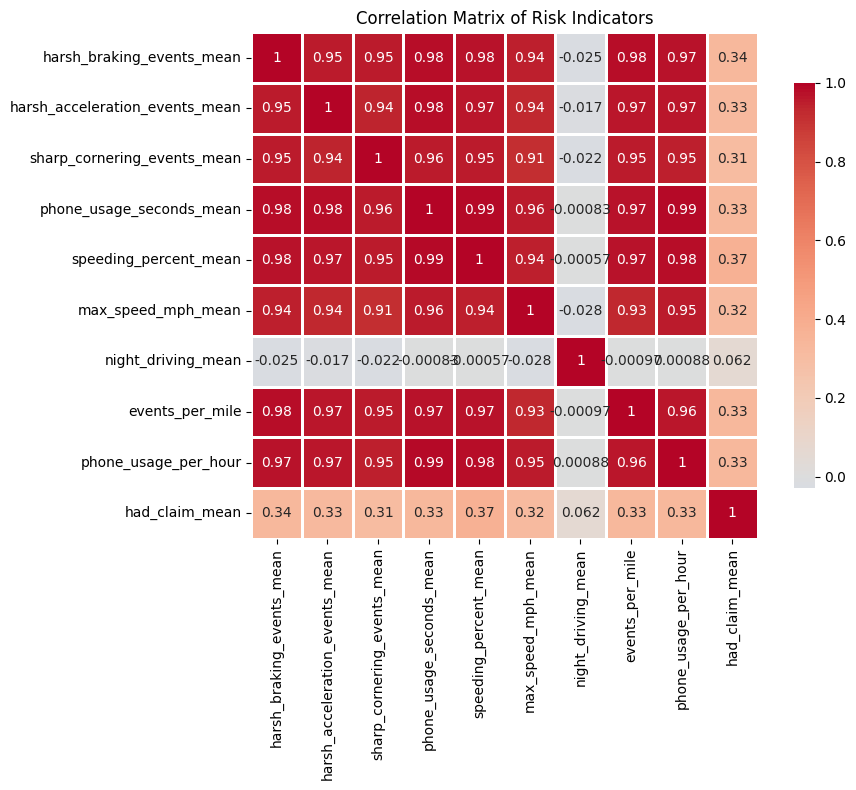

MODEL 1: CLAIM PROBABILITY PREDICTION

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.36      0.45        14
           1       0.59      0.81      0.68        16

    accuracy                           0.60        30
   macro avg       0.61      0.58      0.57        30
weighted avg       0.61      0.60      0.58        30

ROC-AUC Score: 0.6362


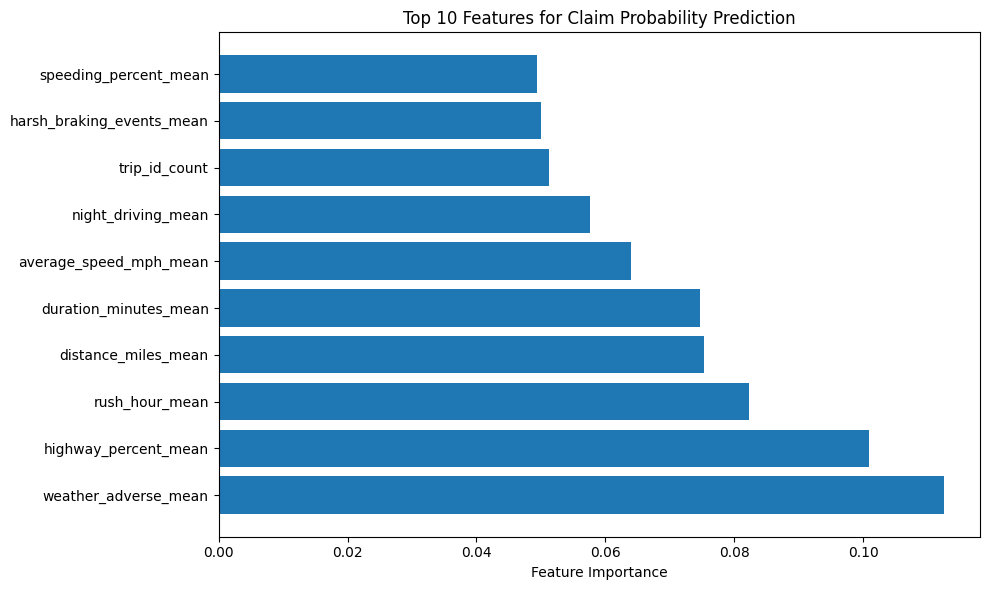


Top 10 Most Important Features:
                      feature  importance
12       weather_adverse_mean    0.112508
11       highway_percent_mean    0.100915
10             rush_hour_mean    0.082281
2         distance_miles_mean    0.075326
1       duration_minutes_mean    0.074747
3      average_speed_mph_mean    0.063928
9          night_driving_mean    0.057607
0               trip_id_count    0.051265
5   harsh_braking_events_mean    0.050034
13      speeding_percent_mean    0.049358

MODEL 2: CLAIM SEVERITY PREDICTION

RMSE for claim severity: $234.42


/tmp/ipykernel_15273/2525718488.py:160: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_factors = df_drivers.groupby('risk_tier')[['harsh_braking_events_mean',


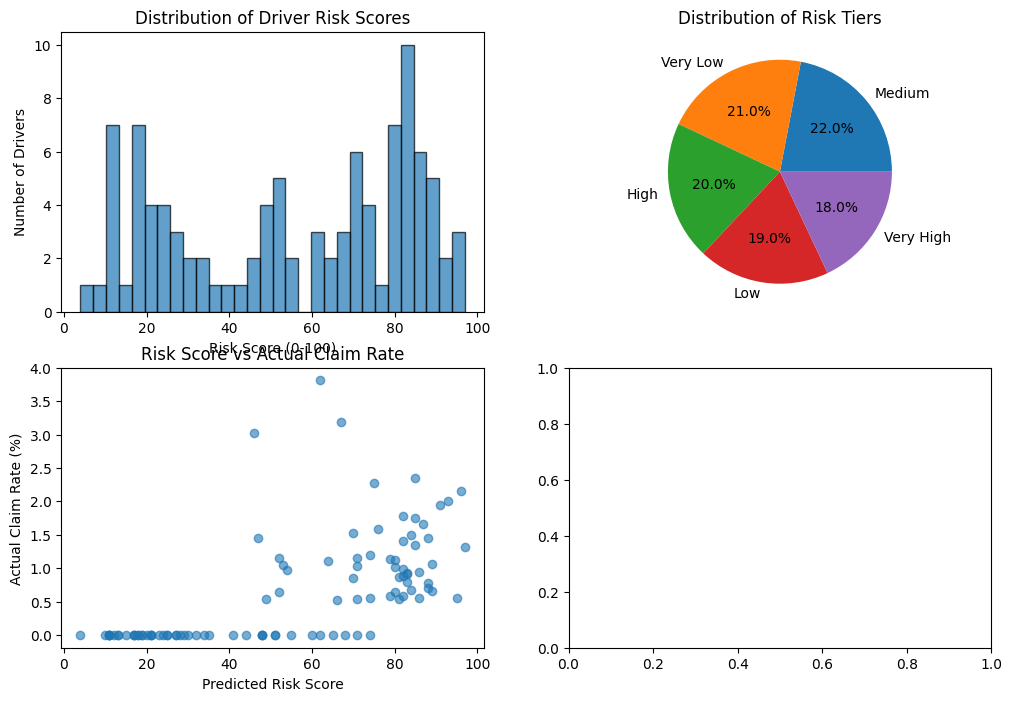

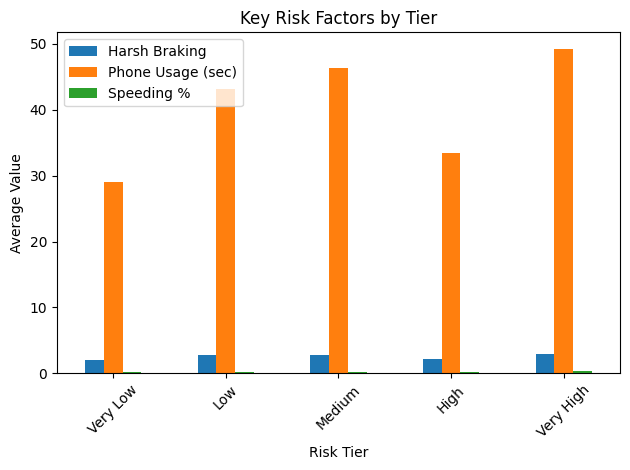


RISK SCORING SUMMARY

Risk Tier Distribution:
risk_tier
Very Low     21
Low          19
Medium       22
High         20
Very High    18
Name: count, dtype: int64

Average Risk Score by Actual Claims:
had_claim_sum
0    30.723404
1    77.857143
2    73.583333
3    78.250000
4    79.000000
Name: risk_score, dtype: float64

Top 5 Highest Risk Drivers:
     driver_id  risk_score  risk_tier  claim_probability  had_claim_sum  \
21  DRIVER_021        97.0  Very High               0.97              2   
83  DRIVER_083        96.0  Very High               0.96              4   
92  DRIVER_092        95.0  Very High               0.95              1   
96  DRIVER_096        93.0  Very High               0.93              2   
9   DRIVER_009        91.0  Very High               0.91              3   

    claim_amount_sum  
21      23340.900770  
83      91214.251052  
92       7656.517380  
96       5648.566764  
9       23633.272557  


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import classification_report, roc_auc_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load the driver-level data
df_drivers = pd.read_csv('driver_aggregated_features.csv')

# 1. FEATURE ENGINEERING
# Create additional risk-related features
df_drivers['events_per_mile'] = (df_drivers['harsh_braking_events_sum'] + 
                                  df_drivers['harsh_acceleration_events_sum'] + 
                                  df_drivers['sharp_cornering_events_sum']) / df_drivers['distance_miles_sum']

df_drivers['phone_usage_per_hour'] = df_drivers['phone_usage_seconds_sum'] / (df_drivers['duration_minutes_sum'] / 60)

df_drivers['night_driving_miles'] = df_drivers['night_driving_mean'] * df_drivers['distance_miles_sum']

df_drivers['speeding_severity'] = df_drivers['speeding_percent_mean'] * df_drivers['max_speed_mph_mean']

# Create risk categories based on claims
df_drivers['risk_category'] = pd.cut(df_drivers['had_claim_mean'], 
                                     bins=[-0.001, 0, 0.01, 0.02, 1], 
                                     labels=['No Risk', 'Low Risk', 'Medium Risk', 'High Risk'])

# 2. EXPLORATORY DATA ANALYSIS
# Create correlation matrix for key features
risk_features = ['harsh_braking_events_mean', 'harsh_acceleration_events_mean', 
                 'sharp_cornering_events_mean', 'phone_usage_seconds_mean',
                 'speeding_percent_mean', 'max_speed_mph_mean', 'night_driving_mean',
                 'events_per_mile', 'phone_usage_per_hour', 'had_claim_mean']

plt.figure(figsize=(10, 8))
correlation_matrix = df_drivers[risk_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Risk Indicators')
plt.tight_layout()
plt.savefig('risk_correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# 3. PREPARE DATA FOR MODELING
# Select features for modeling
feature_cols = ['trip_id_count', 'duration_minutes_mean', 'distance_miles_mean',
                'average_speed_mph_mean', 'max_speed_mph_mean', 
                'harsh_braking_events_mean', 'harsh_acceleration_events_mean',
                'sharp_cornering_events_mean', 'phone_usage_seconds_mean',
                'night_driving_mean', 'rush_hour_mean', 'highway_percent_mean',
                'weather_adverse_mean', 'speeding_percent_mean',
                'events_per_mile', 'phone_usage_per_hour', 'speeding_severity']

X = df_drivers[feature_cols]
y_binary = (df_drivers['had_claim_sum'] > 0).astype(int)  # Binary: had any claim
y_continuous = df_drivers['claim_amount_mean']  # Continuous: average claim amount

# Split data
X_train, X_test, y_train_binary, y_test_binary, y_train_cont, y_test_cont = train_test_split(
    X, y_binary, y_continuous, test_size=0.3, random_state=42, stratify=y_binary
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. MODEL 1: CLAIM PROBABILITY MODEL (Classification)
print("=" * 50)
print("MODEL 1: CLAIM PROBABILITY PREDICTION")
print("=" * 50)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, 
                                      class_weight='balanced')
rf_classifier.fit(X_train_scaled, y_train_binary)

# Predictions
y_pred_binary = rf_classifier.predict(X_test_scaled)
y_pred_proba = rf_classifier.predict_proba(X_test_scaled)[:, 1]

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test_binary, y_pred_binary))
print(f"ROC-AUC Score: {roc_auc_score(y_test_binary, y_pred_proba):.4f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_classifier.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xlabel('Feature Importance')
plt.title('Top 10 Features for Claim Probability Prediction')
plt.tight_layout()
plt.savefig('feature_importance_claims.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10))

# 5. MODEL 2: CLAIM SEVERITY MODEL (Regression)
print("\n" + "=" * 50)
print("MODEL 2: CLAIM SEVERITY PREDICTION")
print("=" * 50)

# Filter only drivers with claims for severity modeling
mask_train = y_train_cont > 0
mask_test = y_test_cont > 0

if mask_train.sum() > 10:  # Only if we have enough samples
    gb_regressor = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gb_regressor.fit(X_train_scaled[mask_train], np.log1p(y_train_cont[mask_train]))
    
    y_pred_severity = np.expm1(gb_regressor.predict(X_test_scaled[mask_test]))
    
    rmse = np.sqrt(mean_squared_error(y_test_cont[mask_test], y_pred_severity))
    print(f"\nRMSE for claim severity: ${rmse:,.2f}")

# 6. COMBINED RISK SCORE
# Create a combined risk score
df_drivers['claim_probability'] = rf_classifier.predict_proba(scaler.transform(X))[:, 1]

# Normalize scores to 0-100 scale
df_drivers['risk_score'] = (df_drivers['claim_probability'] * 100).round(1)

# Create risk tiers
df_drivers['risk_tier'] = pd.qcut(df_drivers['risk_score'], 
                                  q=5, 
                                  labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# 7. RISK PROFILE VISUALIZATION
plt.figure(figsize=(12, 8))

# Subplot 1: Risk Score Distribution
plt.subplot(2, 2, 1)
plt.hist(df_drivers['risk_score'], bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Risk Score (0-100)')
plt.ylabel('Number of Drivers')
plt.title('Distribution of Driver Risk Scores')

# Subplot 2: Risk Tier Distribution
plt.subplot(2, 2, 2)
risk_tier_counts = df_drivers['risk_tier'].value_counts()
plt.pie(risk_tier_counts.values, labels=risk_tier_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Risk Tiers')

# Subplot 3: Risk Score vs Actual Claims
plt.subplot(2, 2, 3)
plt.scatter(df_drivers['risk_score'], df_drivers['had_claim_mean'] * 100, alpha=0.6)
plt.xlabel('Predicted Risk Score')
plt.ylabel('Actual Claim Rate (%)')
plt.title('Risk Score vs Actual Claim Rate')

# Subplot 4: Top Risk Factors by Tier
plt.subplot(2, 2, 4)
risk_factors = df_drivers.groupby('risk_tier')[['harsh_braking_events_mean', 
                                                'phone_usage_seconds_mean', 
                                                'speeding_percent_mean']].mean()
risk_factors.plot(kind='bar')
plt.xlabel('Risk Tier')
plt.ylabel('Average Value')
plt.title('Key Risk Factors by Tier')
plt.xticks(rotation=45)
plt.legend(['Harsh Braking', 'Phone Usage (sec)', 'Speeding %'], loc='upper left')

plt.tight_layout()
plt.savefig('risk_analysis_dashboard.png', dpi=300, bbox_inches='tight')
plt.show()

# 8. SAVE FINAL RISK SCORES
output_df = df_drivers[['driver_id', 'risk_score', 'risk_tier', 'claim_probability',
                       'had_claim_sum', 'claim_amount_sum']].copy()
output_df.to_csv('driver_risk_scores.csv', index=False)

print("\n" + "=" * 50)
print("RISK SCORING SUMMARY")
print("=" * 50)
print(f"\nRisk Tier Distribution:")
print(df_drivers['risk_tier'].value_counts().sort_index())
print(f"\nAverage Risk Score by Actual Claims:")
print(df_drivers.groupby('had_claim_sum')['risk_score'].mean())

# Show sample of high-risk drivers
print("\nTop 5 Highest Risk Drivers:")
high_risk = output_df.nlargest(5, 'risk_score')
print(high_risk)